In [1]:
import chemistry_vae_selfies
import data_loader
import selfies
import torch
import importlib
import yaml
import pandas as pd
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt
import networkx as nx
from pysmiles import read_smiles
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import auxiliary_functions as af
import importlib
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addStereoAnnotation = True

In [2]:
importlib.reload(af) 

<module 'auxiliary_functions' from '/home/carlos/Software/chemDM/auxiliary_functions.py'>

In [2]:
# here we want to read in data and tranform them into one_hot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_path = "./datasets/"
file_name = "SelectedSMILES_QM9.txt"

full_path = folder_path + file_name

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_selfies.get_selfie_and_smiles_encodings_for_dataset(full_path)

--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
selfies aplhabet: ['[Branch1]', '[N]', '[#C]', '[Ring2]', '[Branch2]', '[#Branch2]', '[C]', '[nop]', '[=Branch1]', '[=N]', '[O]', '[=C]', '[Ring1]', '[=O]', '[F]', '[#Branch1]', '[#N]', '[=Branch2]']
smiles aplhabet: [')', '#', 'C', '5', '4', 'F', '3', 'N', 'O', '2', '(', '1', '=', ' ']


In [3]:
# define source file location
file_to_load =  "./saved_models_RNN/"
#file_to_load =  "./model runs/saved_models_run1/"
#file_to_load =  "./saved_models_run1/"
# training file name encoder
training_file_nameE = "300/E"
# training file name decoder
training_file_nameD = "300/D"
# load data
#load_data_trained = file_to_load + training_file_nameE
# Alphabet has 18 letters, largest molecule is 21 letters. (build this as an output function later ... )
largest_selfies_len_dataset = largest_selfies_len
largest_smiles_len_dataset = largest_smiles_len

#in_dimension = len(selfies_alphabet)*largest_selfies_len
in_dimension = len(smiles_alphabet)*largest_smiles_len



# load the trained encoder
vae_encoder = torch.load(file_to_load + training_file_nameE) #, map_location=torch.device(device="cpu"))
#print(vae_encoder)

# load the trained decoder
vae_decoder = torch.load(file_to_load + training_file_nameD) #, map_location=torch.device(device="cpu"))
#print(vae_decoder)

In [4]:
selfies_alphabet = ['[#Branch2]', '[Ring2]', '[Branch2]', '[=Branch2]', '[O]', '[=O]', '[=C]', '[=N]', '[#Branch1]', '[=Branch1]', '[nop]', '[N]', '[Branch1]', '[F]', '[#C]', '[#N]', '[Ring1]', '[C]']


encoded in CC12CC(O)(C1)C=C2
reconstructed out C1C2CC(C)(C21)O
reconstructed out CN1CC(O)(C1)C=CO
reconstructed out CC12CC(N)(C1)CC2
reconstructed out CC12CC(C)(C1)CC2=O
reconstructed out CCC1C(C)(C1)CCO
reconstructed out CN1CC(O)(C)C=C1O
reconstructed out CCCC(C1)CC1
reconstructed out C1C2CC(N)(C2)CC1
reconstructed out CCC1C(O1)(O)C
reconstructed out CC1C2C(O)(C1)CC2=O
reconstructed out CC1CC(O)CCN1
reconstructed out CC1C2C(C)(C2)CC1=O
reconstructed out CC12CC(O)(C1)C=C2
reconstructed out CCCC(O1)(C1)CNOO
reconstructed out CC12CC1(O)C2OC=O
reconstructed out CCN1C(O)(CC)C=C1
reconstructed out CCCC(O1)(C1)CNN
reconstructed out CC12CC(O)(C1)CC2
reconstructed out CC1CC(O)COO1
reconstructed out CC1CC(C)(OC)O1
reconstructed out C1C23CC1(O)C2CC3O
reconstructed out CC1CC(O)(O1)CCN
reconstructed out CC12CC(O)(C1)CC2O
reconstructed out CC12CC(O)(C1)CO2
reconstructed out CC1CC1(C)CCC
reconstructed out CC12CC(O)(C1)OC2O
reconstructed out CC12CC(C)(C1)NO2
reconstructed out CC1CC(N)(C1)NON
reconstr

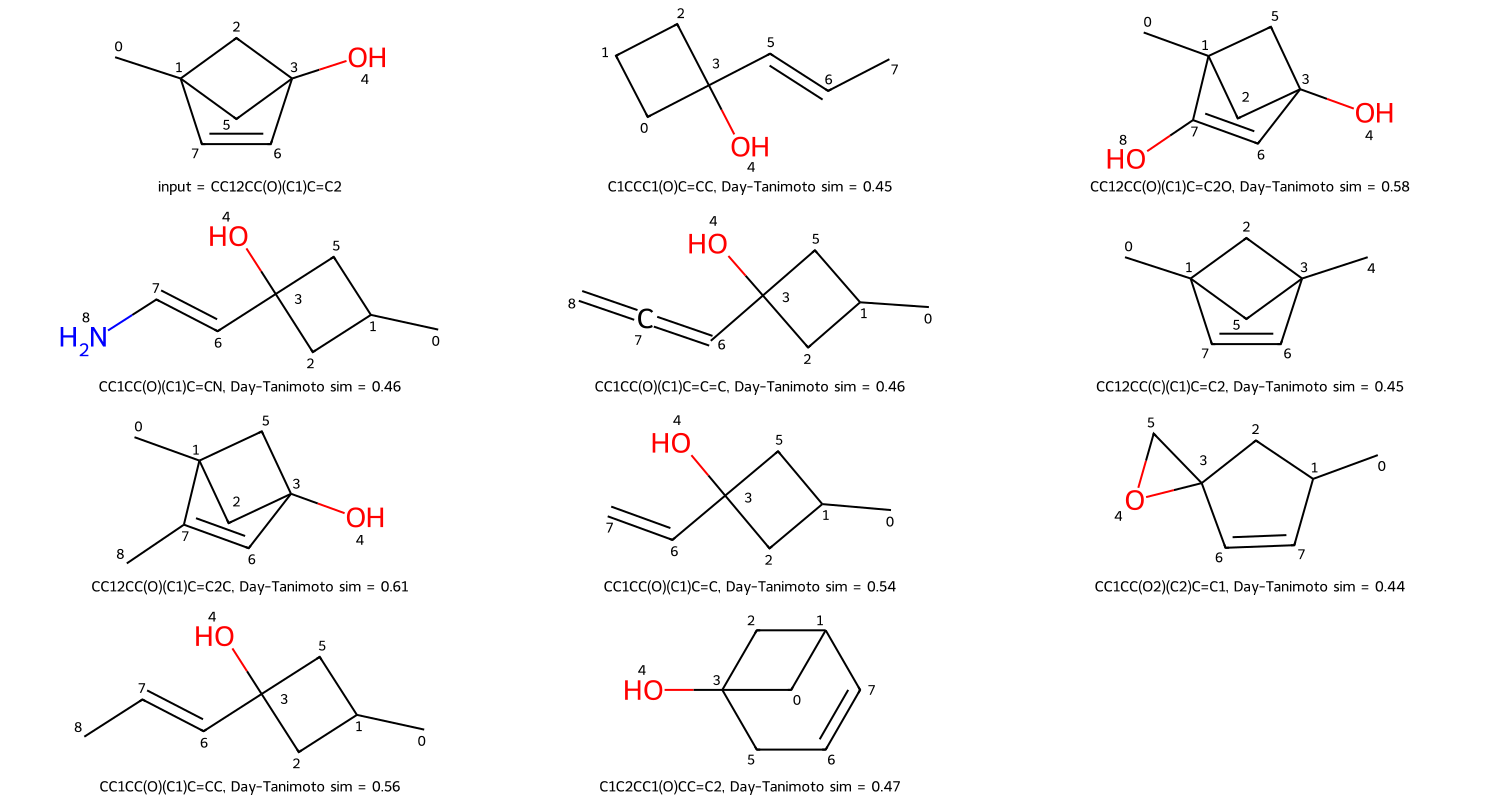

In [13]:
#create fingerprint generator
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator()

#number of molecules to generate from latent space
num_gen = 1000

#similarity threshold
sim_thresh = 0.4

# pick a molecule
selfie_input = selfies_list[6501]

# Reference molecule
ref_mol_smiles = selfies.decoder(selfie_input)
print("encoded in", ref_mol_smiles)
ref_mol = Chem.MolFromSmiles(ref_mol_smiles)

#fingerprints
ref_fps = fpgen.GetFingerprint(ref_mol)

#arrays for molecules 
mols_from_selfies =[]
mols_smiles =[]
mols_selfies =[]
mols_sims =[]

mols_from_selfies.append(ref_mol)


for i in range(num_gen):
    coded_selfie_from_latent_space = af.decode_from_latentspace(vae_encoder, vae_decoder, af.create_latent_space_vector(vae_encoder, vae_decoder,selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),1) 
    selfie_from_latent_space = af.translate_selfie(coded_selfie_from_latent_space,selfies_alphabet)
    print("reconstructed out", selfies.decoder(selfie_from_latent_space))

    #Create a smiles from latent selfies
    smiles_from_selfie = selfies.decoder(selfie_from_latent_space)
    #Create a molecule from the smiles
    mol_from_sefies = Chem.MolFromSmiles(smiles_from_selfie)
    #Create a fingerprint of the generated molecule
    fps = fpgen.GetFingerprint(mol_from_sefies)
    #Compute the Tanimoto similarity between input and reconstuction
    sim=DataStructs.TanimotoSimilarity(ref_fps,fps)

    if (1.0 > sim and sim > sim_thresh)  and (str(smiles_from_selfie) not in mols_smiles):

        #generate mol from decoded selfie and append to array
        mols_from_selfies.append(mol_from_sefies)

        #append smiles code to legends array
        mols_smiles.append(str(smiles_from_selfie))

        #append selfies code to legends array
        mols_selfies.append(str(selfie_from_latent_space))

        #append similarity to sims array
        mols_sims.append(str(round(sim,2)))


#create legends
mols_legends=[x[0]+', Day-Tanimoto sim = '+x[1] for x in zip(mols_smiles,mols_sims)]
mols_legends.insert(0,'input = '+str(ref_mol_smiles))


print(mols_legends)

Draw.MolsToGridImage(mols_from_selfies,subImgSize=(500,200),legends=mols_legends)


encoded in CC12CC(O)(C1)C=C2
reconstructed out CC12CC(C)(C1)OC2
reconstructed out CC1CC(O)CC=C1
reconstructed out CC1CC(C)(C1)OCOO
reconstructed out CC12CC(O)(C1)CC2=O
reconstructed out CCCC(C)(CC)CCO
reconstructed out C1C2CC1(N)C2OC#N
reconstructed out CCCC(N)CCCN
reconstructed out C12CCC1(C)C=C2O
reconstructed out CC1CC(C)=NC=C1O
reconstructed out C1C23CC1(N)C2=NO3
reconstructed out CCC#CO
reconstructed out C1C2CC1(O)C2CCN
reconstructed out C1CCC1(O)CCC
reconstructed out C1CCC1(C)CCC
reconstructed out CC1C2C(C)(C1)CC2O
reconstructed out CC1CC(C)(C)CO1
reconstructed out CC12CC(N)(C1)CC2
reconstructed out CC1C2C(O)(C2)CC1O
reconstructed out CCCC(=O)CC
reconstructed out CCCC(N)C1CC1C
reconstructed out C12CCC2(O)O1
reconstructed out CC1CC(N)(NOC1)O
reconstructed out CCC1C(C)(CC)ON1
reconstructed out C1C23CC1(C)C2CC3
reconstructed out CC1CC(N)CCC1
reconstructed out CCCC(O)(CCC)N
reconstructed out CC12CC(N)(C1)CC2O
reconstructed out C1C2CC1(C3)C3CC2
reconstructed out CC1CC(O)(C1)CON
recons

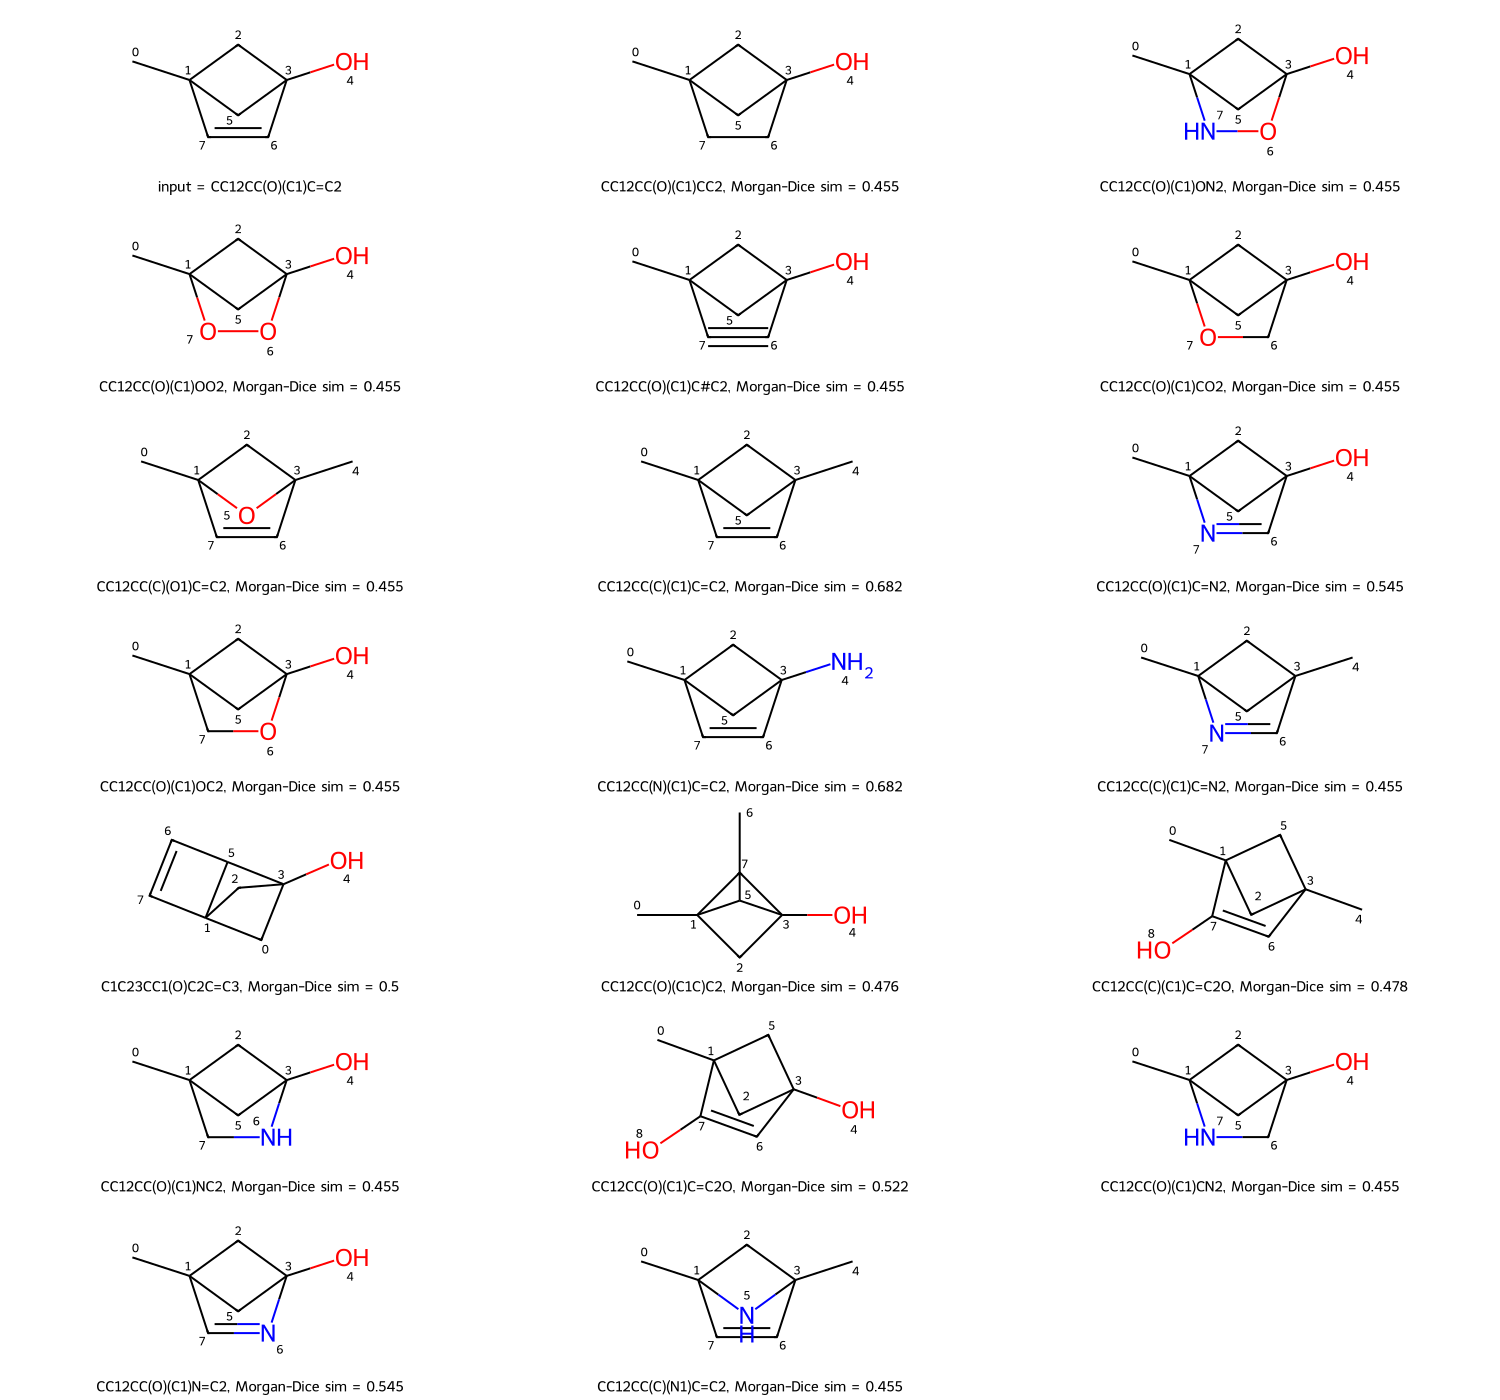

In [14]:
#create fingerprint generator
fpgen = AllChem.GetMorganGenerator(radius=3)

#number of molecules to generate from latent space
num_gen = 1000

#similarity threshold
sim_thresh = 0.45

# pick a molecule
selfie_input = selfies_list[6501]

# Reference molecule
ref_mol_smiles = selfies.decoder(selfie_input)
print("encoded in", ref_mol_smiles)
ref_mol = Chem.MolFromSmiles(ref_mol_smiles)

#fingerprints
ref_fps = fpgen.GetSparseCountFingerprint(ref_mol)

#arrays for molecules 
mols_from_selfies =[]
mols_smiles =[]
mols_selfies =[]
mols_sims =[]

mols_from_selfies.append(ref_mol)


for i in range(num_gen):
    coded_selfie_from_latent_space = af.decode_from_latentspace(vae_encoder, vae_decoder, af.create_latent_space_vector(vae_encoder, vae_decoder,selfie_input,largest_selfies_len,selfies_alphabet) , largest_selfies_len, len(selfies_alphabet),1) 
    selfie_from_latent_space = af.translate_selfie(coded_selfie_from_latent_space,selfies_alphabet)
    print("reconstructed out", selfies.decoder(selfie_from_latent_space))

    #Create a smiles from latent selfies
    smiles_from_selfie = selfies.decoder(selfie_from_latent_space)
    #Create a molecule from the smiles
    mol_from_sefies = Chem.MolFromSmiles(smiles_from_selfie)
    #Create a fingerprint of the generated molecule
    fps = fpgen.GetSparseCountFingerprint(mol_from_sefies)
    #Compute the Tanimoto similarity between input and reconstuction
    sim = DataStructs.DiceSimilarity(ref_fps,fps)

    if (1.0 > sim and sim > sim_thresh)  and (str(smiles_from_selfie) not in mols_smiles):

        #generate mol from decoded selfie and append to array
        mols_from_selfies.append(mol_from_sefies)

        #append smiles code to legends array
        mols_smiles.append(str(smiles_from_selfie))

        #append selfies code to legends array
        mols_selfies.append(str(selfie_from_latent_space))

        #append similarity to sims array
        mols_sims.append(str(round(sim,3)))


#create legends
mols_legends=[x[0]+', Morgan-Dice sim = '+x[1] for x in zip(mols_smiles,mols_sims)]
mols_legends.insert(0,'input = '+str(ref_mol_smiles))

Draw.MolsToGridImage(mols_from_selfies,subImgSize=(500,200),legends=mols_legends)

